# Preprocessing of GEX and ADT data from DOGMA-seq and ASAP-seq data
As detailed in 00_Overview.ipynb

### scRNA-seq data of DOGMA-seq

In [1]:
# Imports
import glob
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

#### RNA (only applicable to DOGMA-seq datasets)
 - pct_mito < 30
 - n_total_rna > 1000 ~< (10^4.5)~
 - Use data adaptive threshold as upper threshold instead Q3 + 1.5x IQR (after having removed/excluding cells with low counts (<= 1000)!) n_total_rna <= q3 + 1.5 * iqr for top boundary!
 - n_feature_rna > 500
 - drop mitochondrial genes from analysis


In [2]:
# Path to original DOGMA-seq data
wd = "./../../data/original/Mimitou2021/DOGMA_seq/"

In [3]:
# What is in this directory
! ls -l ./../../data/original/Mimitou2021/DOGMA_seq/

total 5
drwxr-sr-x 5 prauten AG_Ohler 4096 Nov 30 13:40 DIG_CTRL
drwxr-sr-x 6 prauten AG_Ohler 4096 Nov 30 13:44 DIG_STIM
drwxr-sr-x 5 prauten AG_Ohler 4096 Dec  2 11:17 LLL_CTRL
drwxr-sr-x 6 prauten AG_Ohler 4096 Nov 30 13:25 LLL_STIM
drwxr-sr-x 4 prauten AG_Ohler 4096 Jan 25 17:20 multiome_pbmc_stim


In [4]:
# Paths to all DOGMA-seq datasets
subfolders = [ f.path for f in os.scandir(wd) if f.is_dir() and not os.path.basename(f).startswith(".") and not "multiome_pbmc_stim" in f.path ]
subfolders

['./../../../data/original/Mimitou2021/DOGMA_seq/DIG_CTRL',
 './../../../data/original/Mimitou2021/DOGMA_seq/LLL_CTRL',
 './../../../data/original/Mimitou2021/DOGMA_seq/LLL_STIM',
 './../../../data/original/Mimitou2021/DOGMA_seq/DIG_STIM']

In [5]:
def process_scRNA(adata, remove_outliers=True):
    """
    Based on R implementation accompanying Mimitou et al., 2021 publication
    https://github.com/caleblareau/asap_reproducibility/blob/master/pbmc_stim_multiome/code/11_setup.R
    
    Implements similar filtering with additional optional removal of "top" outliers disregarding low count (<= 100 cells)
    """
    # Remove crazy high and low expressors
    # n_feature_rna <- colSums(raw > 0)
    n_feature_rna = np.array((adata.X > 0).sum(axis=1).flatten().tolist()[0])  
    # n_total_rna <- colSums(raw)
    n_total_rna =  np.array(adata.X.sum(axis=1).flatten().tolist()[0])
    # pct_mito <- colSums(raw[grepl("^MT", rownames(raw)), ])/n_total_rna * 100
    # Note: using ^MT as in original does include some non-mitochondrial genes!
    mt_genes = adata.var.filter(regex = "^MT-", axis=0)
    pct_mito = np.array(adata[:,adata.var.isin(mt_genes)["gene_ids"]].X.sum(axis=1).flatten().tolist()[0])/np.array(n_total_rna) * 100
    # qc_cells <- colnames(raw)[pct_mito < 30 & n_total_rna > 1000 & n_feature_rna > 500]
    if remove_outliers:
        n_total_rna_no_small = n_total_rna[n_total_rna > 1000]
        q1 = np.quantile(n_total_rna_no_small, 0.25)
        q3 = np.quantile(n_total_rna_no_small, 0.75)
        iqr = q3 - q1      
        remove_upper_outliers = n_total_rna <= q3 + 1.5 * iqr
        upper_threshold = q3 + 1.5 * iqr
        percent_removed = (remove_upper_outliers.shape[0] - np.count_nonzero(remove_upper_outliers))/remove_upper_outliers.shape[0]
        min_outlier = n_total_rna[remove_upper_outliers].max()
        print("{:2.2%} of samples were removed. Smallest outlier had {:d} GEX counts.".format(percent_removed, int(min_outlier)))
        qc_cells  = (pct_mito < 30) & (n_total_rna > 1000) & (n_feature_rna > 500) & (n_total_rna < upper_threshold)
    else:
        qc_cells  = (pct_mito < 30) & (n_total_rna > 1000) & (n_feature_rna > 500) & (n_total_rna < 10**4.5)
    # Filter for singlet cells and non-mito genes
    # raw <- raw[!grepl("^MT", rownames(raw)), qc_cells]
    return adata[qc_cells, ~adata.var.isin(mt_genes)["gene_ids"]].copy()

In [6]:
# Preprocess all DOGMA-seq datasets
adata_RNA_dict = dict()
for directory in subfolders:
    sample = "DOGMA_" + os.path.basename(directory)
    print(sample)
    adata_RNA_dict[sample] = process_scRNA(sc.read_10x_mtx(directory + "/RNA/"), remove_outliers=True)

DOGMA_DIG_CTRL
5.86% of samples were removed. Smallest outlier had 4636 GEX counts.
DOGMA_LLL_CTRL
8.53% of samples were removed. Smallest outlier had 7389 GEX counts.
DOGMA_LLL_STIM
7.21% of samples were removed. Smallest outlier had 11485 GEX counts.
DOGMA_DIG_STIM
7.24% of samples were removed. Smallest outlier had 7212 GEX counts.


In [7]:
adata_RNA_dict.keys()

dict_keys(['DOGMA_DIG_CTRL', 'DOGMA_LLL_CTRL', 'DOGMA_LLL_STIM', 'DOGMA_DIG_STIM'])

In [8]:
adata_RNA_dict.values()

dict_values([AnnData object with n_obs × n_vars = 9531 × 36588
    var: 'gene_ids', 'feature_types', AnnData object with n_obs × n_vars = 7298 × 36588
    var: 'gene_ids', 'feature_types', AnnData object with n_obs × n_vars = 5990 × 36588
    var: 'gene_ids', 'feature_types', AnnData object with n_obs × n_vars = 9142 × 36588
    var: 'gene_ids', 'feature_types'])

In [9]:
# Order by sample name
sample_names = sorted(adata_RNA_dict.keys())
sample_names

['DOGMA_DIG_CTRL', 'DOGMA_DIG_STIM', 'DOGMA_LLL_CTRL', 'DOGMA_LLL_STIM']

In [10]:
# Combine datasets
adata_concat_RNA =  sc.AnnData.concatenate(*[adata_RNA_dict[key] for key in sample_names],
                                           join='inner', batch_key='batch',
                                           batch_categories=sample_names,
                                           uns_merge=None, index_unique='_', fill_value=None)

In [11]:
adata_concat_RNA                                         

AnnData object with n_obs × n_vars = 31961 × 36588
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [12]:
# Look at library size distribution

In [13]:
RNA_libsize_dist = [adata_concat_RNA[adata_concat_RNA.obs["batch"] == batch].X.sum(axis=1).flatten().tolist()[0] for batch in adata_concat_RNA.obs["batch"].unique()]

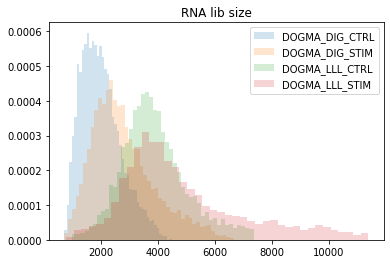

In [14]:
for lib_dist, batch in zip(RNA_libsize_dist, adata_concat_RNA.obs["batch"].unique()):
    plt.hist(lib_dist, bins="auto", label=batch, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("RNA lib size")
plt.show()

In [15]:
RNA_log_libsize_dist = [np.log(adata_concat_RNA[adata_concat_RNA.obs["batch"] == batch].X.sum(axis=1).flatten().tolist()[0]) for batch in adata_concat_RNA.obs["batch"].unique()]

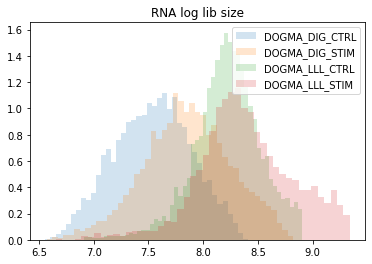

In [16]:
for lib_dist, batch in zip(RNA_log_libsize_dist, adata_concat_RNA.obs["batch"].unique()):
    plt.hist(lib_dist, bins="auto", label=batch, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("RNA log lib size")
plt.show()

In [17]:
# Total umi counts per cell
adata_concat_RNA.obs["counts"] = adata_concat_RNA.X.sum(axis=1).flatten().tolist()[0]

<AxesSubplot:>

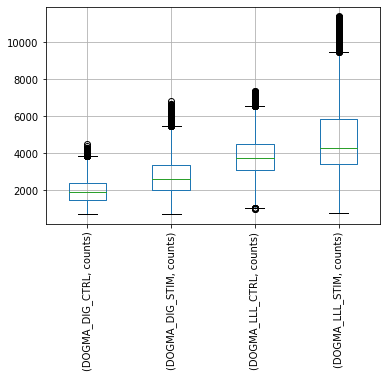

In [18]:
adata_concat_RNA.obs.groupby("batch").boxplot("counts", rot=90)

<AxesSubplot:xlabel='counts', ylabel='batch'>

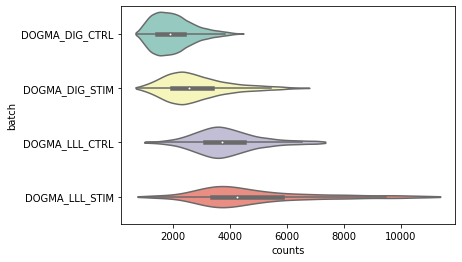

In [19]:
sns.violinplot(x=adata_concat_RNA.obs['counts'], y=adata_concat_RNA.obs['batch'], cut=0, scale="area", palette="Set3")

In [20]:
adata_concat_RNA.X.sum(axis=1).max()

11383.0

In [21]:
adata_concat_RNA.X.sum(axis=1).shape

(31961, 1)

In [22]:
adata_concat_RNA.X.sum(axis=1).min()

705.0

<AxesSubplot:xlabel='counts'>

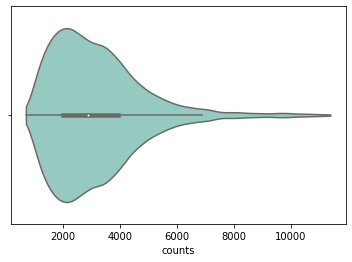

In [23]:
sns.violinplot(x=adata_concat_RNA.obs['counts'], cut=0, scale="area", palette="Set3")

<AxesSubplot:>

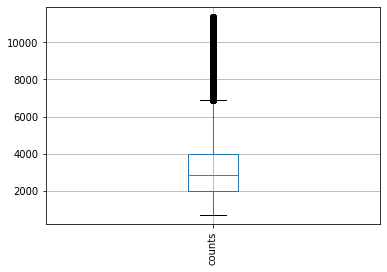

In [24]:
adata_concat_RNA.obs.boxplot("counts", rot=90)

## ADT
 - total tags need to be <= 25,000 and > 100
 - ASAP: tags measured from the rat isotype controls <=75 
 - DOGMA: totalCTRLadt < 10 (I think there is no such thing in the DOGMA-seq data, in the original code they do a regex search for "Ctrl" on the protein names, and there are none) - This was an error: index was unnamed! There are isotype controls!
 - ~((CD8_counts > 30) & (CD4_counts > 100))
 - don't remove high counts, as these are most likely the cells of interest..
 

ASAP-seq: 4 Rat isotype control features

DOGMA-seq: 2 Rat isotype control features

ADT feature names need to be matched and missing removed between technolgies/datasets

Subset ASAP features to DOGMA subset, do counting of Ctrl features before subsetting!

### DOGMA-seq

In [25]:
def process_DOGMA_ADT(adata):
    """
    Based on R implementation accompanying Mimitou et al., 2021 publication
    https://github.com/caleblareau/asap_reproducibility/blob/master/pbmc_stim_multiome/code/11_setup.R
    &
    https://github.com/caleblareau/asap_reproducibility/blob/master/pbmc_stimulation_asapseq_citeseq/code/01_ADT_preprocess_ASAP.R
    """
    n_total_adt =  np.array(adata.X.sum(axis=1).flatten().tolist()[0])
    ctrl_genes = adata.var.filter(regex = "Ctrl", axis=0)
    ctrl_counts = np.array(adata[:,adata.var.isin(ctrl_genes)["protein_names"]].X.sum(axis=1).flatten().tolist()[0])
    CD8_counts = np.array(adata[:,'CD8'].X.sum(axis=1).flatten().tolist()[0])
    CD4_counts = np.array(adata[:,'CD4-1'].X.sum(axis=1).flatten().tolist()[0])
    qc_cells  = (n_total_adt <= 25000) & (n_total_adt > 100) & (ctrl_counts < 10) & ~((CD8_counts > 30) & (CD4_counts > 100))
    return adata[qc_cells, :].copy()

In [26]:
# Preprocess all DOGMA-seq datasets
adata_protein_dict = dict()
for directory in subfolders:
    sample = "DOGMA_" + os.path.basename(directory)
    print(sample)
    directory = directory + "/ADT/"
    print(directory)
    # Read matrix in MatrixMarket format
    tmp_adata = sc.read(directory + "matrix.mtx.gz")
    # Read in barcodes
    barcodes = pd.read_csv(directory + "barcodes.tsv.gz", header=None, names=["barcodes"])
    # Make names match with RNA barcodes
    barcodes["barcodes"] = barcodes["barcodes"] + "-1"
    tmp_adata.obs.set_index(barcodes["barcodes"], inplace=True)
    features = pd.read_csv(directory +  "features.tsv.gz", header=None, names=["protein_names"])
    tmp_adata.var = features
    tmp_adata.var.index = tmp_adata.var["protein_names"]
    adata_protein_dict[sample] = process_DOGMA_ADT(tmp_adata)

DOGMA_DIG_CTRL
./../../../data/original/Mimitou2021/DOGMA_seq/DIG_CTRL/ADT/
DOGMA_LLL_CTRL
./../../../data/original/Mimitou2021/DOGMA_seq/LLL_CTRL/ADT/
DOGMA_LLL_STIM
./../../../data/original/Mimitou2021/DOGMA_seq/LLL_STIM/ADT/
DOGMA_DIG_STIM
./../../../data/original/Mimitou2021/DOGMA_seq/DIG_STIM/ADT/


In [27]:
adata_protein_dict

{'DOGMA_DIG_CTRL': AnnData object with n_obs × n_vars = 81663 × 210
     var: 'protein_names',
 'DOGMA_LLL_CTRL': AnnData object with n_obs × n_vars = 15623 × 210
     var: 'protein_names',
 'DOGMA_LLL_STIM': AnnData object with n_obs × n_vars = 21427 × 210
     var: 'protein_names',
 'DOGMA_DIG_STIM': AnnData object with n_obs × n_vars = 83382 × 210
     var: 'protein_names'}

In [28]:
# Path to original DOGMA-seq data
wd_ASAP = "./../../data/original/Mimitou2021/ASAP_seq/"

In [29]:
# What is in this directory
! ls -l ./../../data/original/Mimitou2021/ASAP_seq/

total 3
drwxr-sr-x 4 prauten AG_Ohler 4096 Nov 30 14:20 LLL_CTRL
drwxr-sr-x 4 prauten AG_Ohler 4096 Nov 30 14:29 LLL_STIM
drwxr-sr-x 2 prauten AG_Ohler 4096 Dec  1 12:07 from_asap_large_data_files


In [30]:
ASAP_subfolders = [ f.path for f in os.scandir(wd_ASAP) if f.is_dir() and not os.path.basename(f).startswith(".") and not os.path.basename(f).startswith("from") ]
ASAP_subfolders

['./../../../data/original/Mimitou2021/ASAP_seq/LLL_CTRL',
 './../../../data/original/Mimitou2021/ASAP_seq/LLL_STIM']

In [31]:
# Mapping between ASAP-seq and DOGMA-seq features
ADT_mapping_ASAP_to_DOGMA = { "CD275.1" : "CD275-1",
 "CD11b.1" : "CD11b-1",
 "Galectin.9" : "Galectin-9",
 "CD155.PVR.": "CD155(PVR)",
 "CD112.Nectin.2." : "CD112(Nectin-2)",
 "CD3.1" : "CD3-1",
 "CD4.1" : "CD4-1",
 "CD56.NCAM." : "CD56(NCAM)",
 "CD45.1" : "CD45-1",
 "CD3.2" : "CD3-2",
 "CD138.1.Syndecan.1." : "CD138-1(Syndecan-1)",
 "CD269.BCMA." : "CD269(BCMA)",
 "CD90.Thy1." : "CD90(Thy1)",
 "CD117.c.kit." : "CD117(c-kit)",
 "CD4.2" : "CD4-2",
 "CD44.1" : "CD44-1",
 "CD56.NCAM.Recombinant" : "CD56(NCAM)Recombinant",
 "CD44.2" : "CD44-2",
 "CD133.1" : "CD133-1",
 "HLA.DR" : "HLA-DR",
 "CD11b.2" : "CD11b-2",
 "CD66a.c.e" : "CD66a/c/e",
 "Siglec.8" : "Siglec-8",
 "CD38.1" : "CD38-1",
 "CD45.2" : "CD45-2",
 "B7.H4" : "B7-H4",
 "CD38.2" : "CD38-2",
 "TCR_V_24.J_18" : "TCR_V_24-J_18",
 "LOX.1" : "LOX-1",
 "CD133.2" : "CD133-2",
 "CD11a.CD18" : "CD11a/CD18",
 "CD307c.FcRL3" : "CD307c/FcRL3",
 "CD138.2" : "CD138-2"
}

In [32]:
unmapped_ASAP = [ "TIGIT",
"CD1d",
"CD272",
"CD275.2",
"Rat_IgG1l_IsotypeCtrl",
"Rat_IgG2c_IsotypeCtrl",
"CD122",
"CD267",
"CD184",
"CD193",
"CD115",
"CD172a",
"CD85g",
"Folate_Receptor",
"TIM.4",
"C5L2",
"TCR_V_9"]

In [33]:
def process_ASAP_ADT(adata):
    adata.var["protein_names"] = adata.var.index
    adata.var["protein_names"] = adata.var["protein_names"].replace(ADT_mapping_ASAP_to_DOGMA)
    adata.var.index = adata.var["protein_names"]
    # Determine ctrl counts before subsetting to only subset of shared features, as threshold was determined for all features
    ctrl_genes = adata.var.filter(regex = "Ctrl", axis=0)
    ctrl_counts = adata[:,adata.var.isin(ctrl_genes)["protein_names"]].X.sum(axis=1).copy()
    adata = adata[:,~adata.var.index.isin(unmapped_ASAP)].copy()
    CD8_counts = adata[:,'CD8'].X.sum(axis=1).copy()
    CD4_counts = adata[:,'CD4-1'].X.sum(axis=1).copy()    
    n_total_adt = adata.X.sum(axis=1)
    qc_cells  = (n_total_adt <= 25000) & (n_total_adt > 100) & (ctrl_counts <= 75) & ~((CD8_counts > 30) & (CD4_counts > 100))  # (CD8_counts <= 30) & (CD4_counts <= 100)
    return adata[qc_cells, :].copy()

In [34]:
# Preprocess all ASAP-seq datasets
for directory in ASAP_subfolders:
    sample = "ASAP_" + os.path.basename(directory)
    print(sample)
    directory = directory + "/ADT/"
    print(directory)
    # Read matrix in MatrixMarket format
    tmp_adata_df = pd.read_csv(glob.glob(directory + "*.tsv.gz")[0], sep="\t", index_col=0)
    adata_protein_dict[sample] = process_ASAP_ADT(sc.AnnData(tmp_adata_df))

ASAP_LLL_CTRL
./../../../data/original/Mimitou2021/ASAP_seq/LLL_CTRL/ADT/
ASAP_LLL_STIM
./../../../data/original/Mimitou2021/ASAP_seq/LLL_STIM/ADT/


In [35]:
# Order by sample name
sample_names = sorted(adata_protein_dict.keys())
sample_names

['ASAP_LLL_CTRL',
 'ASAP_LLL_STIM',
 'DOGMA_DIG_CTRL',
 'DOGMA_DIG_STIM',
 'DOGMA_LLL_CTRL',
 'DOGMA_LLL_STIM']

In [36]:
adata_protein_dict.values()

dict_values([AnnData object with n_obs × n_vars = 81663 × 210
    var: 'protein_names', AnnData object with n_obs × n_vars = 15623 × 210
    var: 'protein_names', AnnData object with n_obs × n_vars = 21427 × 210
    var: 'protein_names', AnnData object with n_obs × n_vars = 83382 × 210
    var: 'protein_names', AnnData object with n_obs × n_vars = 63325 × 210
    var: 'protein_names', AnnData object with n_obs × n_vars = 63351 × 210
    var: 'protein_names'])

In [37]:
# Combine datasets
adata_concat_protein =  sc.AnnData.concatenate(*[adata_protein_dict[key] for key in sample_names],
                                           join='inner', batch_key='batch',
                                           batch_categories=sample_names,
                                           uns_merge=None, index_unique='_', fill_value=None)

In [38]:
adata_concat_protein

AnnData object with n_obs × n_vars = 328771 × 210
    obs: 'batch'
    var: 'protein_names'

In [39]:
# Look at library size distribution

In [40]:
protein_libsize_dist = [adata_concat_protein[adata_concat_protein.obs["batch"] == batch].X.sum(axis=1).flatten().tolist()[0] for batch in adata_concat_protein.obs["batch"].unique()]

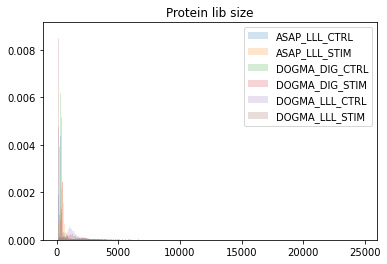

In [41]:
for lib_dist, batch in zip(protein_libsize_dist, adata_concat_protein.obs["batch"].unique()):
    plt.hist(lib_dist, bins="auto", label=batch, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("Protein lib size")
plt.show()

In [42]:
protein_log_libsize_dist = [np.log(adata_concat_protein[adata_concat_protein.obs["batch"] == batch].X.sum(axis=1).flatten().tolist()[0]) for batch in adata_concat_protein.obs["batch"].unique()]

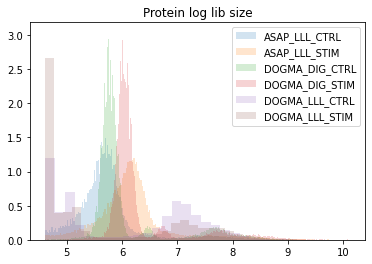

In [43]:
for lib_dist, batch in zip(protein_log_libsize_dist, adata_concat_protein.obs["batch"].unique()):
    plt.hist(lib_dist, bins="auto", label=batch, density=True, alpha=0.2)
    plt.legend(loc='upper right')
    plt.title("Protein log lib size")
plt.show()

In [44]:
adata_concat_protein.X.sum(axis=1).max()

24770.0

In [45]:
adata_concat_protein.X.sum(axis=1).shape

(328771, 1)

In [46]:
adata_concat_protein.X.sum(axis=1).min()

101.0

In [47]:
adata_concat_protein.obs["counts"] = adata_concat_protein.X.sum(axis=1).flatten().tolist()[0]

<AxesSubplot:>

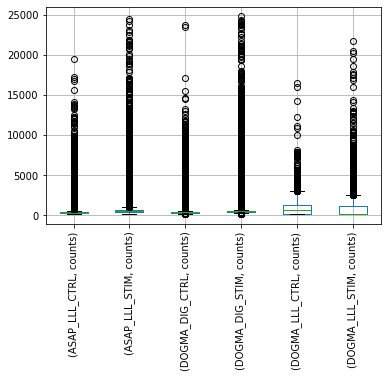

In [48]:
adata_concat_protein.obs.groupby("batch").boxplot("counts", rot=90)

<AxesSubplot:xlabel='counts'>

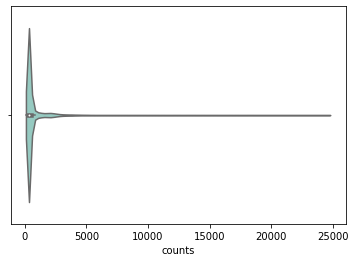

In [49]:
sns.violinplot(x=adata_concat_protein.obs['counts'], cut=0, scale="area", palette="Set3")

<AxesSubplot:>

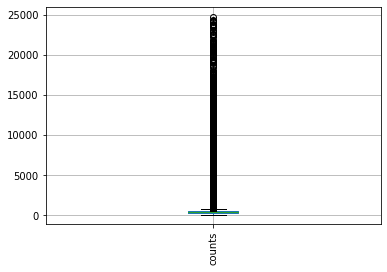

In [50]:
adata_concat_protein.obs.boxplot("counts", rot=90)

<AxesSubplot:xlabel='counts', ylabel='batch'>

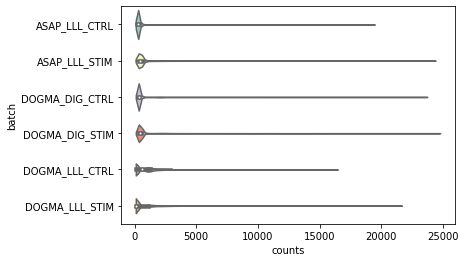

In [51]:
sns.violinplot(x=adata_concat_protein.obs['counts'], y=adata_concat_protein.obs['batch'], cut=0, scale="area", palette="Set3")

## Load preprocessed ATAC data

In [52]:
# Get preprocessed ATAC data (informative features called with scregseg)
adata_concat_ATAC = sc.read_h5ad("./../../data/derived/Mimitou2021/ATAC/all_datasets_informative_rarest_states_out_of_50_0.h5ad").T

## Combine data from distinct modalities

In [53]:
DOGMA = adata_concat_RNA[(adata_concat_RNA.obs.index.isin(adata_concat_ATAC.obs.index)) & (adata_concat_RNA.obs.index.isin(adata_concat_protein.obs.index)),:].copy()


In [54]:
DOGMA

AnnData object with n_obs × n_vars = 27497 × 36588
    obs: 'batch', 'counts'
    var: 'gene_ids', 'feature_types'

In [55]:
DOGMA.obsm["ATAC"] = adata_concat_ATAC[DOGMA.obs.index,:].X

In [56]:
DOGMA.obsm["ADT"] = adata_concat_protein[DOGMA.obs.index,:].X

In [57]:
DOGMA.write_h5ad("./../../data/derived/Mimitou2021/DOGMA_seq/preprocessed_DOGMA.h5ad")

In [58]:
# Save RNA only for reference based annotation

In [59]:
DOGMA_RNA_only = DOGMA.copy()

In [60]:
DOGMA_RNA_only.obsm = None

In [61]:
# DOGMA_RNA_only.write_h5ad("./../../data/derived/Mimitou2021/DOGMA_seq/preprocessed_DOGMA_RNA_only.h5ad")

/home/prauten/miniconda3/envs/lpr_scregseg/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


In [62]:
ATAC_ADT = adata_concat_ATAC[adata_concat_ATAC.obs.index.isin(adata_concat_protein.obs.index),:].copy()  

In [63]:
ATAC_ADT.obsm["ADT"] = adata_concat_protein[ATAC_ADT.obs.index,:].X

In [64]:
# ATAC_ADT.write_h5ad("./../../data/derived/Mimitou2021/ATAC_ADT/preprocssed_ATAC_ADT.h5ad")

In [65]:
def display_data_distribution(adata):
    protein_log_libsize_dist = [np.log(adata[adata.obs["batch"] == batch].obsm["ADT"].sum(axis=1).flatten().tolist()[0]) for batch in adata.obs["batch"].unique()]
    for lib_dist, batch in zip(protein_log_libsize_dist, adata.obs["batch"].unique()):
        plt.hist(lib_dist, bins="auto", label=batch, density=True, alpha=0.2)
        plt.legend(loc='upper right')
        plt.title("Protein log lib size")
    plt.show()
    
    if "ATAC" in adata.obsm.keys():
        atac_log_libsize_dist = [np.log(adata[adata.obs["batch"] == batch].obsm["ATAC"].sum(axis=1).flatten().tolist()[0]) for batch in adata.obs["batch"].unique()]
        rna_log_libsize_dist = [np.log(adata[adata.obs["batch"] == batch].X.sum(axis=1).flatten().tolist()[0]) for batch in adata.obs["batch"].unique()]

    else:
        atac_log_libsize_dist = [np.log(adata[adata.obs["batch"] == batch].X.sum(axis=1).flatten().tolist()[0]) for batch in adata.obs["batch"].unique()]
        rna_log_libsize_dist = None
    
    for lib_dist, batch in zip(atac_log_libsize_dist, adata.obs["batch"].unique()):
        plt.hist(lib_dist, bins="auto", label=batch, density=True, alpha=0.2)
        plt.legend(loc='upper right')
        plt.title("ATAC log lib size")
    plt.show()
    
    if rna_log_libsize_dist is not None:
        for lib_dist, batch in zip(rna_log_libsize_dist, adata.obs["batch"].unique()):
            plt.hist(lib_dist, bins="auto", label=batch, density=True, alpha=0.2)
            plt.legend(loc='upper right')
            plt.title("GEX log lib size")
        plt.show()
    
    


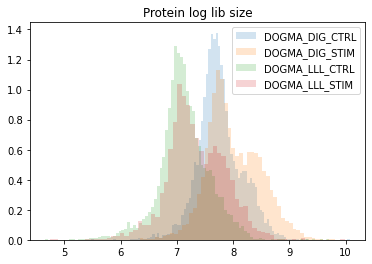

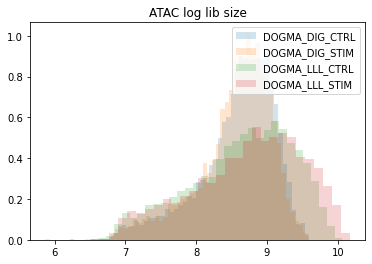

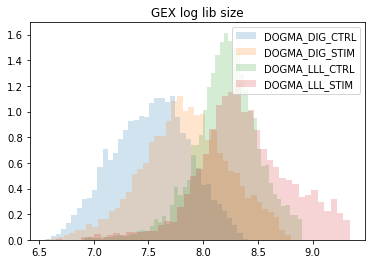

In [66]:
display_data_distribution(DOGMA)

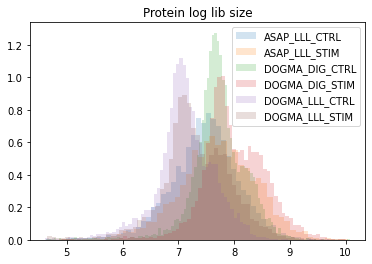

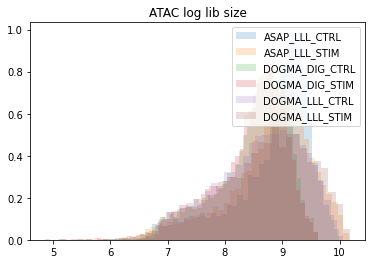

In [67]:
display_data_distribution(ATAC_ADT)

In [68]:
DOGMA

AnnData object with n_obs × n_vars = 27497 × 36588
    obs: 'batch', 'counts'
    var: 'gene_ids', 'feature_types'
    obsm: 'ATAC', 'ADT'

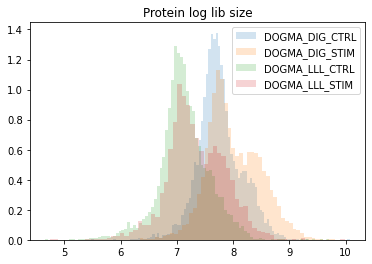

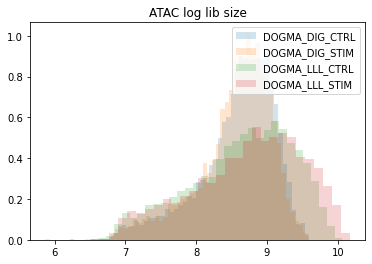

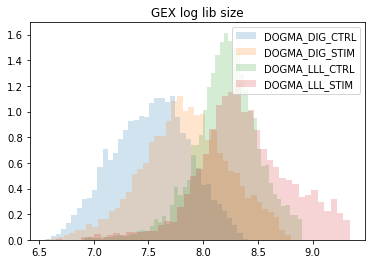

In [79]:
display_data_distribution(DOGMA)

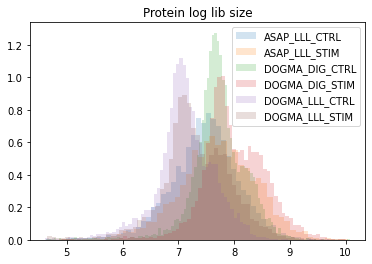

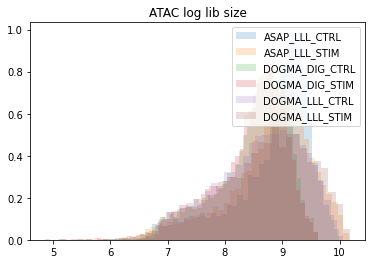

In [82]:
display_data_distribution(ATAC_ADT)